In [2]:
import wandb
import pandas
import numpy as np
import matplotlib.pyplot as plt

In [3]:
interesting_runs = []
api = wandb.Api()


In [4]:
runs = api.runs("user_nameame/project_name")
for run in runs:
    if run.state == 'finished':
        interesting_runs.append(run)
extra_runs = api.runs("user_nameame/project_name")
for run in extra_runs:
    if run.state == 'finished':
        interesting_runs.append(run)


In [5]:
groups = {}
configs = {}
for mode in ['tb', 'reverse_kl', 'rws', 'forward_kl', 'reverse_rws', 'modified_db']:
    for sampling_mode in ['on_policy', 'pure_off_policy', 'off_policy']:
        name = f"{mode}_{sampling_mode}"
        groups[name] = []
        configs[name] = []
        for run in interesting_runs:
            if run.config['mode'] == mode and run.config['sampling_mode'] == sampling_mode:
                groups[name].append(run.history())
                configs[name].append(run.config)

excluded_keys = ['seed', 'wandb', 'offset', 'no_cuda', 'task_id', 'config_id', 'gradient_estimation_interval', 'validation_interval', 'total']
def get_group_average(group, column_name):
    "takes a list of dataframes as input and returns a numpy array of the average of the column across the dataframes, and same for std"
    return (np.mean(np.array([np.array(df[column_name].astype(float)) for df in group]), axis=0),
     np.std(np.array([np.array(df[column_name].astype(float)) for df in group]), axis=0))
def where_different(list_of_tuples):
    "Returns the list of indices where the values in the tuples are different"
    return [i for i, x in enumerate(zip(*list_of_tuples)) if len(set(x)) > 1]

def discrimative_tuples(list_of_tuples):
    out = []
    for tupl in list_of_tuples:
        new_tupl = (val for i, val in enumerate(tupl) if i in where_different(list_of_tuples))
        out.append(tuple(new_tupl))
    return out

short_keys = {'exploration_phase_ends_by': 'exp', 'replay_capacity': 'rep', 'lr_scheduling': 'lrs', 'schedule': 'sch', 'baseline': 'b'}
for key in configs['tb_on_policy'][0].keys():
    if key not in short_keys:
        short_keys[key] = key

def group_by_everything_but_excluded_keys(group, configs, excluded_keys):
    "takes a list of dataframes and a list of configs and returns a dictionary of dataframes grouped by everything but the excluded_keys"
    groups = {}
    for i, config in enumerate(configs):
        new_key = tuple([(key, config[key]) for key in list(config.keys()) if key not in excluded_keys])
        if new_key not in groups:
            groups[new_key] = []
        groups[new_key].append(group[i])
    return groups


In [66]:
# Here, we compare the baselines for modes that have a baseline, next we will plot them
reinforce_groups = {k: v for k, v in groups.items() if (k.startswith('reverse') or k.startswith('forward_kl')) and "pure" not in k}
best_key_per_mode_and_baseline = {f"{key}_local": float('inf') for key in reinforce_groups.keys()}
best_key_per_mode_and_baseline.update({f"{key}_global": float('inf') for key in reinforce_groups.keys()})
best_key_per_mode_and_baseline.update({f"{key}_None": float('inf') for key in reinforce_groups.keys()})

for name in reinforce_groups.keys():
    gs = group_by_everything_but_excluded_keys(groups[name], configs[name], excluded_keys)
    keys = list(gs.keys())
    discriminative_keys = discrimative_tuples(keys)
    best_auc = float('inf')
    for key, discriminative_key in zip(keys, discriminative_keys):
        if dict(discriminative_key)['baseline'] == 'None':
            continue
        pretty_discriminative_key = ", ".join([f"{short_keys[k]}={v}" for k, v in discriminative_key])
        mean, std = get_group_average(gs[key], 'jsd')
        auc = np.trapz(np.nan_to_num(mean[10:], nan=1.))
        if auc < best_auc:
            best_auc = auc
            best_key_per_mode_and_baseline[f"{name}_{dict(discriminative_key)['baseline']}"] = key
        states_visited = get_group_average(gs[key], 'states_visited')[0]
        standard_error = std / np.sqrt(len(gs[key]))


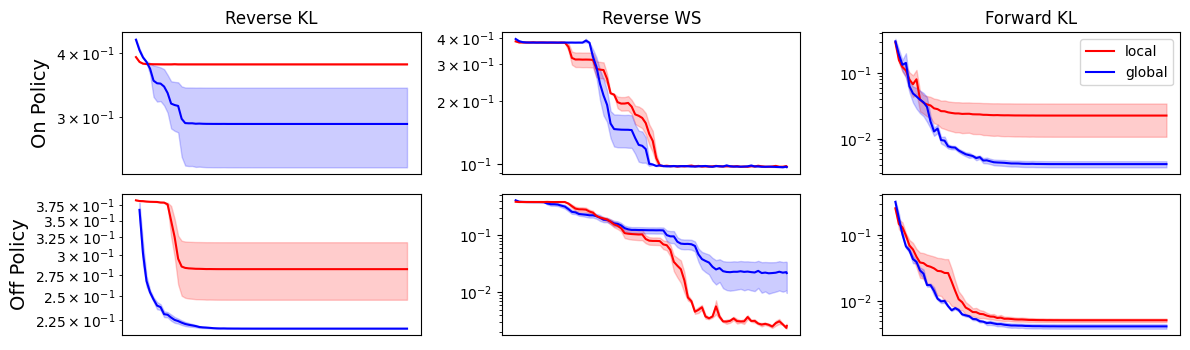

In [105]:
fig = plt.figure(figsize=(12, 3.6))
fig.set_tight_layout(True)
pretty_sampling_modes = ['On Policy', 'Off Policy']
pretty_modes = ['Reverse KL', 'Reverse WS', 'Forward KL']
for i, sampling_mode in enumerate(['on_policy', 'off_policy']):
    for j, mode in enumerate(['reverse_kl', 'reverse_rws', 'forward_kl']):
        name = f"{mode}_{sampling_mode}"
        ax = plt.subplot2grid((2, 3), (i, j), colspan=1, rowspan=1)
        gs = group_by_everything_but_excluded_keys(groups[name], configs[name], excluded_keys)
        keys = list(gs.keys())
        discriminative_keys = discrimative_tuples(keys)
        for key, discriminative_key in zip(keys, discriminative_keys):
            if key not in best_key_per_mode_and_baseline.values():
                continue
            pretty_discriminative_key = ", ".join([f"{short_keys[k]}={v}" for k, v in discriminative_key])
            mean, std = get_group_average(gs[key], 'jsd')
            states_visited = get_group_average(gs[key], 'states_visited')[0]
            standard_error = std / np.sqrt(len(gs[key]))
            baseline = dict(discriminative_key)['baseline']
            color='r' if baseline == 'local' else 'b' if baseline == 'global' else 'g'
            ax.plot(states_visited, mean, label=baseline, color=color)
            ax.fill_between(states_visited, mean - standard_error, mean + standard_error, color=color, alpha=0.2)
        ax.set_xticks([])
        ax.set_yscale('log')
        # ax.set_ylim(1e-3, 1)
        if i == 0:
            ax.set_title(pretty_modes[j])
        if j == 0:
            ax.set_ylabel(pretty_sampling_modes[i], fontsize=14)
        if i == 0 and j == 2:
            ax.legend()
plt.savefig('importance_of_baseline.pdf', bbox_inches='tight')
plt.show()



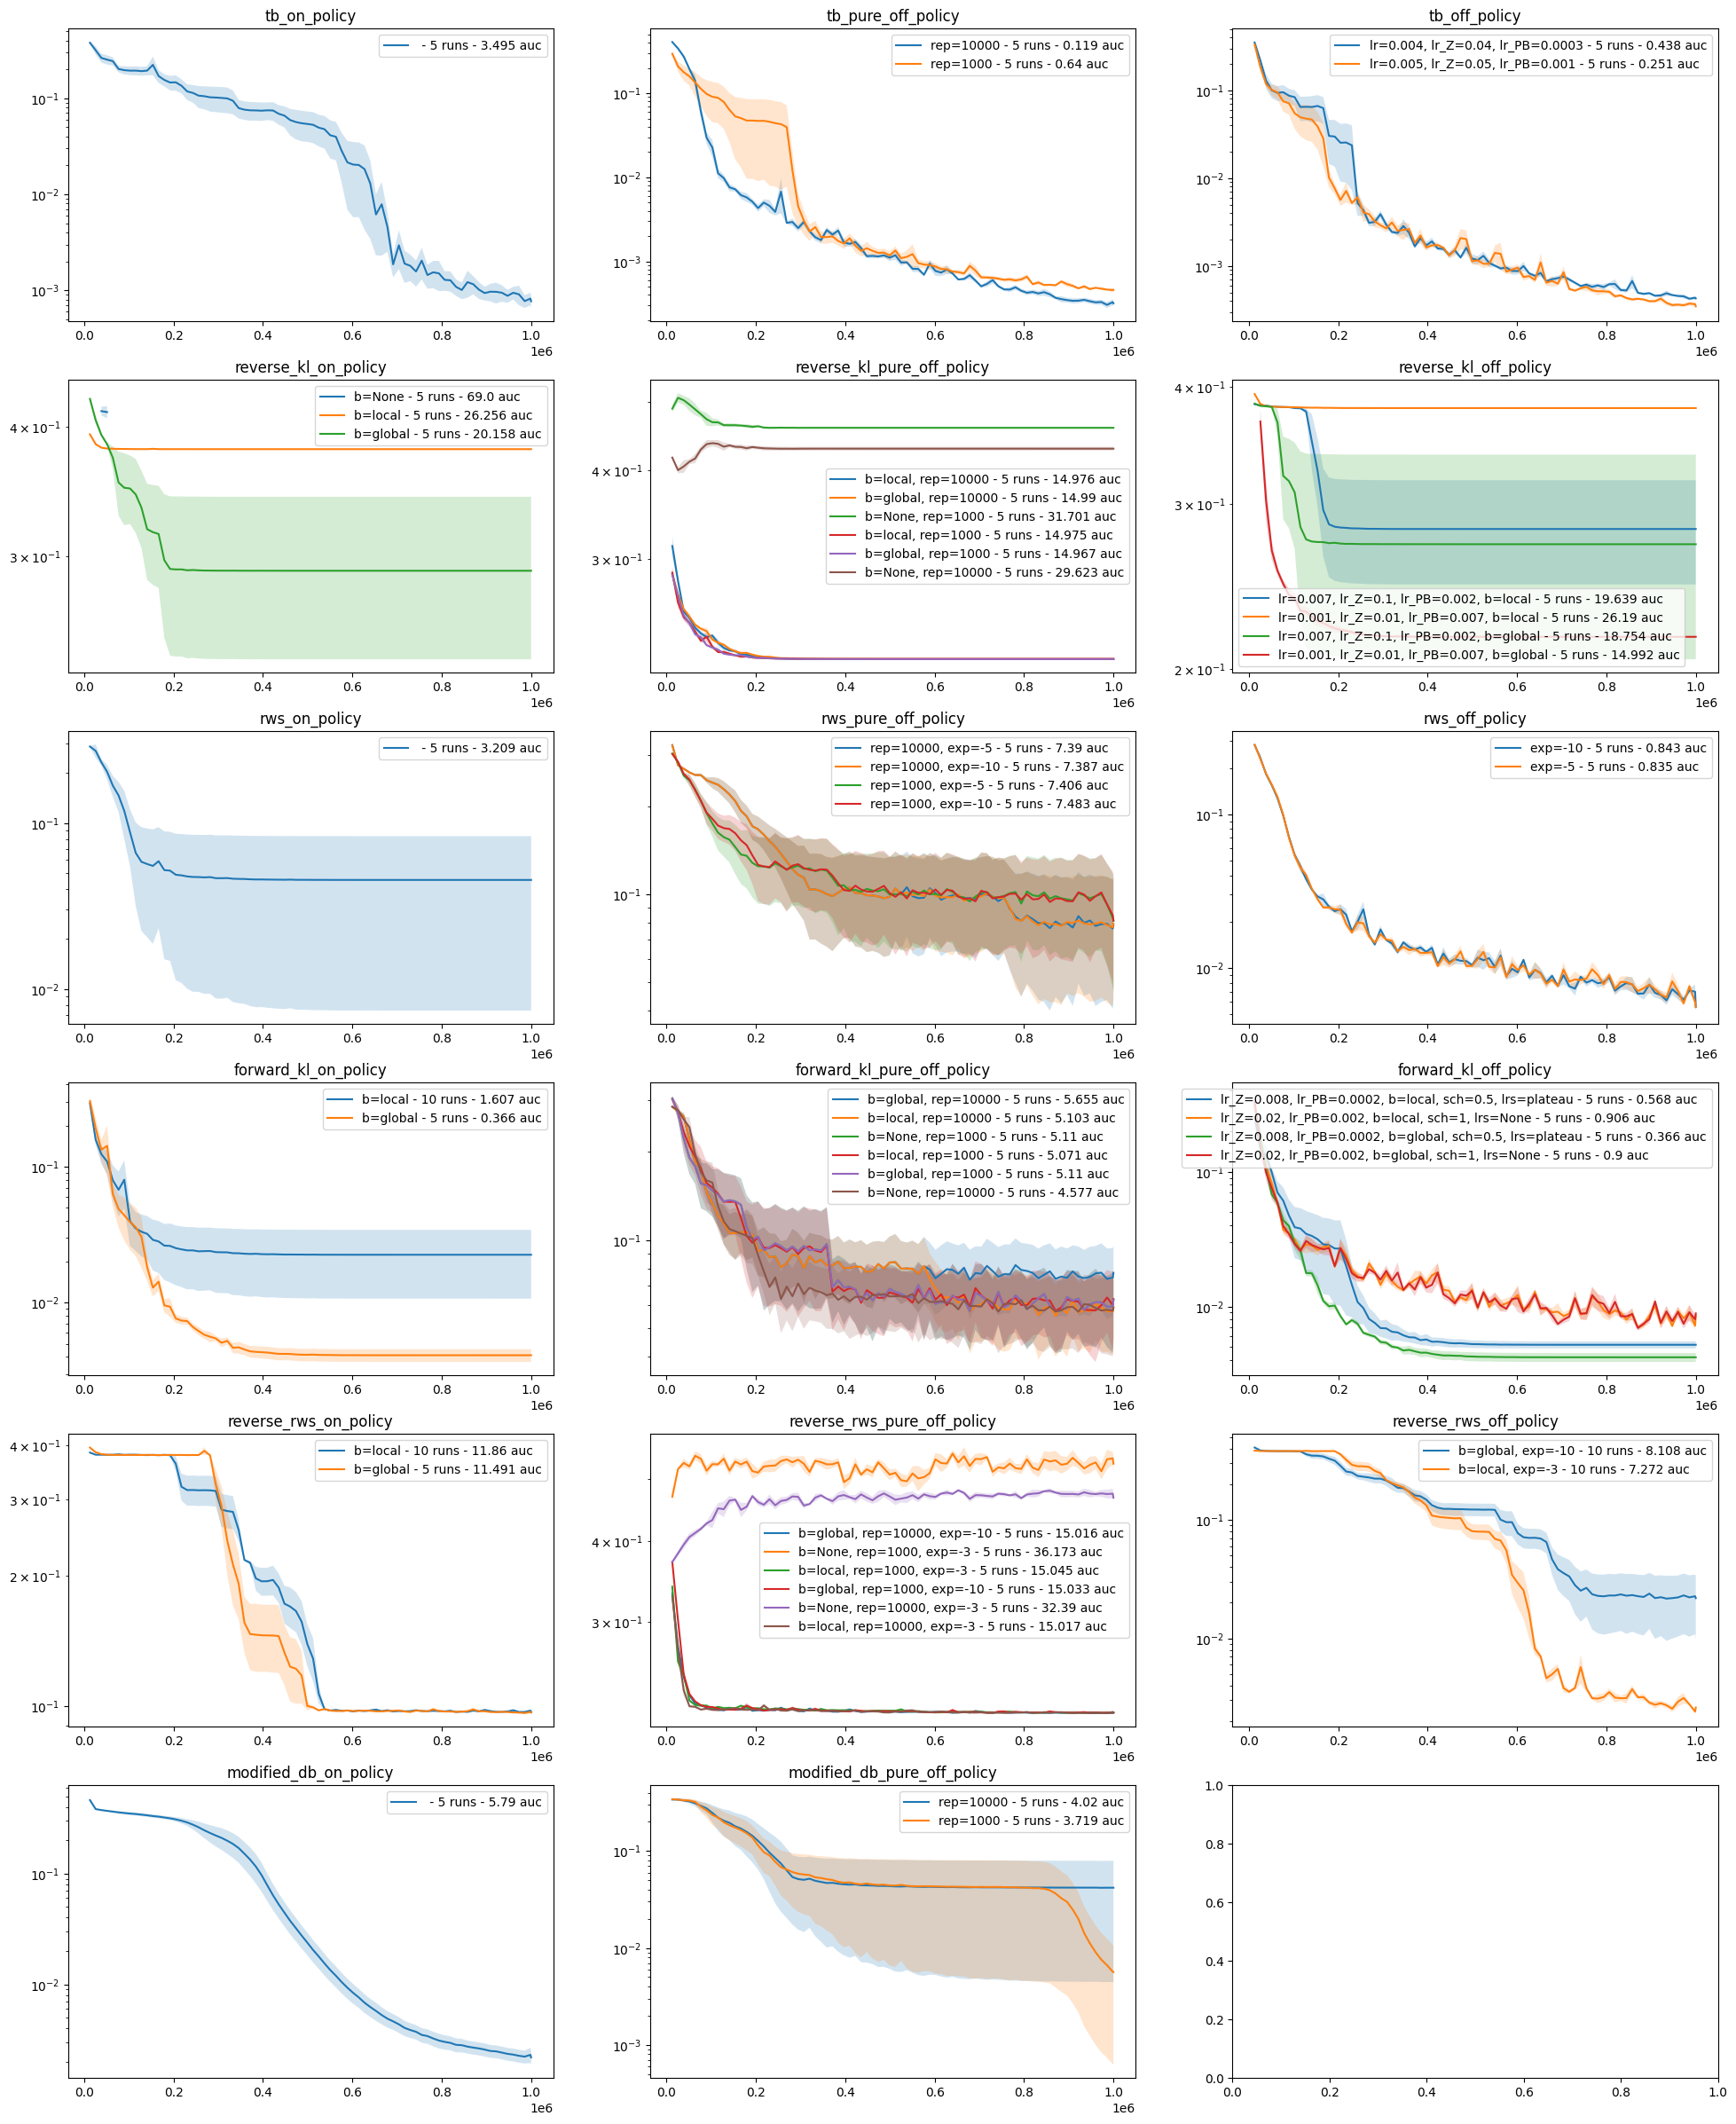

In [11]:
# Here, we show all modes and sampling modes, and for each of them the different configs tried (averaged over seeds)

plt.subplots(6, 3, figsize=(24, 30))
best_key_per_mode = {}
for name in groups.keys():
    gs = group_by_everything_but_excluded_keys(groups[name], configs[name], excluded_keys)
    keys = list(gs.keys())
    discriminative_keys = discrimative_tuples(keys)
    best_auc = float('inf')
    for key, discriminative_key in zip(keys, discriminative_keys):
        pretty_discriminative_key = ", ".join([f"{short_keys[k]}={v}" for k, v in discriminative_key])
        mean, std = get_group_average(gs[key], 'jsd')
        auc = np.trapz(np.nan_to_num(mean[10:], nan=1.))
        if auc < best_auc:
            best_auc = auc
            best_key_per_mode[name] = key
        states_visited = get_group_average(gs[key], 'states_visited')[0]
        standard_error = std / np.sqrt(len(gs[key]))
        plt.subplot(6, 3, list(groups.keys()).index(name) + 1)
        plt.plot(states_visited, mean, label=f"{pretty_discriminative_key} - {len(gs[key])} runs - {np.round(auc, 3)} auc")
        plt.fill_between(states_visited, mean - standard_error, mean + standard_error, alpha=0.2)
        ax = plt.gca()
        ax.set_yscale('log')
        plt.title(name)
        plt.legend()
plt.show()


In [12]:
better_mode_names = {'tb': 'TB', 'reverse_kl': 'Reverse KL', 'rws': 'WS', 'forward_kl': 'Forward KL', 'reverse_rws': 'Reverse WS', 'modified_db': 'Modified DB'}

/var/folders/48/q7zy1z255gbbzwwgxlsz6s980000gn/T/ipykernel_90872/1747544371.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels([f"{int(x/1000)}k" for x in axes[i].get_xticks()])


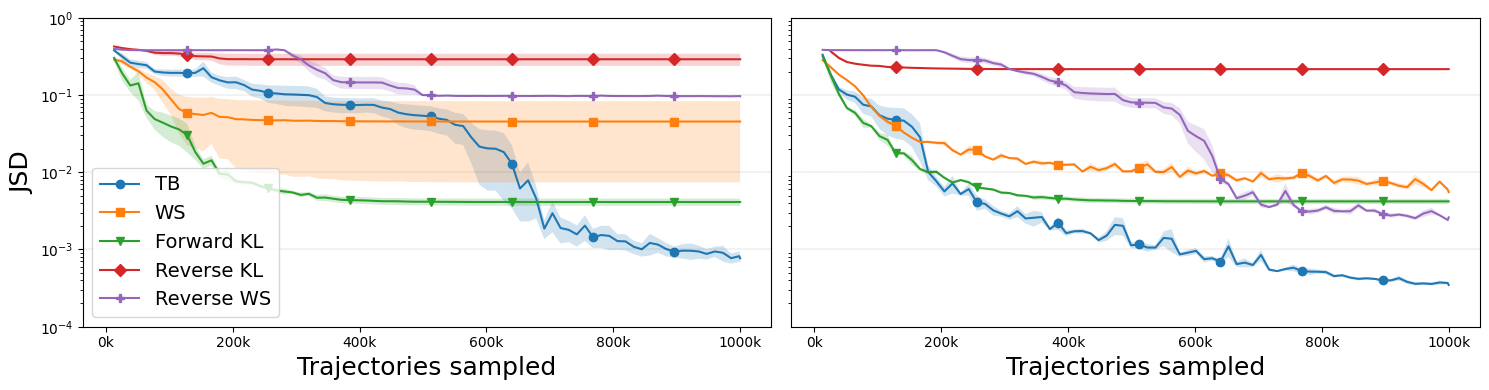

In [14]:
# fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
fig.set_tight_layout(True)
markers = ['o', 's', 'v', 'D', 'P', 'H', 'X']
# for i, sampling_mode in enumerate(['on_policy', 'off_policy', 'pure_off_policy']):
for i, sampling_mode in enumerate(['on_policy', 'off_policy']):
    for j, mode in enumerate(['tb', 'rws', 'forward_kl', 'reverse_kl', 'reverse_rws']):
        name = f"{mode}_{sampling_mode}"
        gs = group_by_everything_but_excluded_keys(groups[name], configs[name], excluded_keys)
        key = best_key_per_mode[name]
        mean, std = get_group_average(gs[key], 'jsd')
        states_visited = get_group_average(gs[key], 'states_visited')[0]
        standard_error = std / np.sqrt(len(gs[key]))
        axes[i].plot(states_visited, mean, label=f"{better_mode_names[mode]}", marker=markers[j], markevery=10)
        axes[i].fill_between(states_visited, mean - standard_error, mean + standard_error, alpha=0.2)
    axes[i].set_yscale('log')

    axes[i].set_ylim(1e-4, 1)
    if i == 0:
        axes[i].legend(prop={'size': 14})
        axes[i].set_ylabel('JSD', fontsize=18)
    if i != 0:
        axes[i].set_yticks([])
    axes[i].set_xlabel('Trajectories sampled', fontsize=18)
    axes[i].set_xticklabels([f"{int(x/1000)}k" for x in axes[i].get_xticks()])
    # add thin horizontal lines
    for y in [1e-3, 1e-2, 1e-1]:
        axes[i].axhline(y=y, color='k', linestyle='--', linewidth=0.1)
plt.savefig('comparing_all_modes_on_off_policy.pdf', bbox_inches='tight')
plt.show()


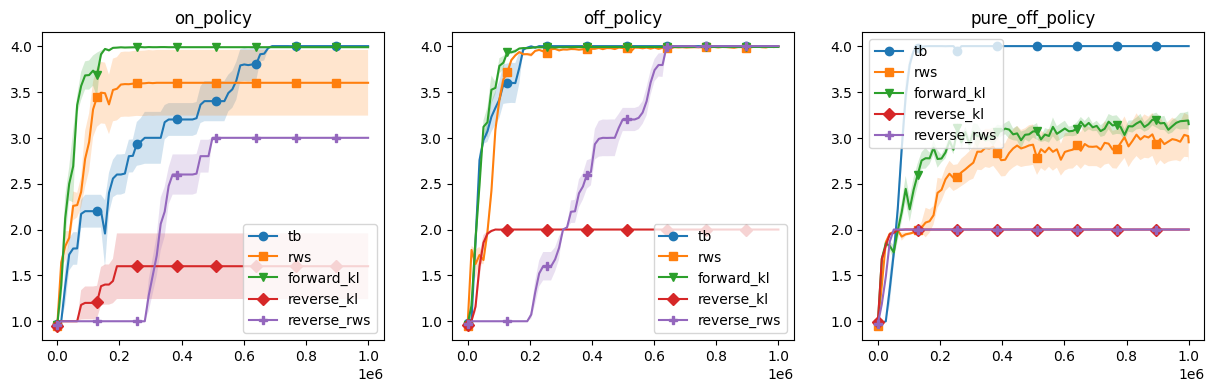

In [60]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
markers = ['o', 's', 'v', 'D', 'P', 'H', 'X']
for i, sampling_mode in enumerate(['on_policy', 'off_policy', 'pure_off_policy']):
    for j, mode in enumerate(['tb', 'rws', 'forward_kl', 'reverse_kl', 'reverse_rws']):
        name = f"{mode}_{sampling_mode}"
        gs = group_by_everything_but_excluded_keys(groups[name], configs[name], excluded_keys)
        key = best_key_per_mode[name]
        mean, std = get_group_average(gs[key], 'modes_found')
        states_visited = get_group_average(gs[key], 'states_visited')[0]
        standard_error = std / np.sqrt(len(gs[key]))
        axes[i].plot(states_visited, mean, label=f"{mode}", marker=markers[j], markevery=10)
        axes[i].fill_between(states_visited, mean - standard_error, mean + standard_error, alpha=0.2)
    axes[i].set_title(sampling_mode)
    axes[i].legend()


plt.show()


In [63]:
def is_dict_consistent_with_list_of_tuples(d, l):
    # Checks if the values in the dictionary are consistent with the values in the list of tuples, for the common keys
    for key in d.keys():
        if key in [elem[0] for elem in l]:
            if d[key] != [elem[1] for elem in l if elem[0] == key][0]:
                return False
    return True

In [64]:
# download images of 2d distributions

import os
for run in interesting_runs:
    mode = run.config['mode']
    sampling_mode = run.config['sampling_mode']
    name = f"{mode}_{sampling_mode}"
    best_key = best_key_per_mode[name]
    if not is_dict_consistent_with_list_of_tuples(run.config, best_key):
        continue
    print(f"Processing {run.name}")
    iteration = max([int(x['path'].split('P_T_')[1].split('_')[0]) for x in run.history()['P_T'].values])
    name = f"{run.config['mode']}_{run.config['sampling_mode']}_best_{run.config['seed']}"
    for file in run.files():
        if 'P_T' in file.name and str(iteration) in file.name:
            file.download(replace=True)
            file_directory = os.path.join(os.getcwd(), 'media', 'images')
            os.rename(file.name, os.path.join(file_directory, f"{name}.png"))

Processing hvi_paper_final_182
Processing hvi_paper_final_184
Processing hvi_paper_final_178
Processing hvi_paper_final_164
Processing hvi_paper_final_159
Processing hvi_paper_final_161
Processing hvi_paper_final_158
Processing hvi_paper_final_157
Processing hvi_paper_final_155
Processing hvi_paper_final_151
Processing hvi_paper_final_156
Processing hvi_paper_final_153
Processing hvi_paper_final_189
Processing hvi_paper_final_144
Processing hvi_paper_final_146
Processing hvi_paper_final_140
Processing hvi_paper_final_121
Processing hvi_paper_final_123
Processing hvi_paper_final_126
Processing hvi_paper_final_117
Processing hvi_paper_final_120
Processing hvi_paper_final_119
Processing hvi_paper_final_118
Processing hvi_paper_final_115
Processing hvi_paper_final_113
Processing hvi_paper_final_106
Processing hvi_paper_final_108
Processing hvi_paper_final_102
Processing hvi_paper_final_85
Processing hvi_paper_final_88
Processing hvi_paper_final_79
Processing hvi_paper_final_83
Processing h

In [15]:

from PIL import Image
import os
import matplotlib

def filename_to_mode(filename):
    if 'forward_kl' in filename:
        return 'Forward KL'
    elif 'reverse_kl' in filename:
        return 'Reverse KL'
    elif 'reverse_rws' in filename:
        return 'Reverse RWS'
    elif 'modified_db' in filename:
        return 'Modified DB'
    elif 'tb' in filename:
        return 'Trajectory Balance'
    elif 'rws' in filename:
        return 'RWS'
    else:
        return 'Unknown'

def filename_to_sampling_mode(filename):
    if 'on_policy' in filename:
        return 'On-Policy'
    elif 'off_policy' in filename and 'pure' not in filename:
        return 'Off-Policy'
    elif 'pure_off_policy' in filename:
        return 'Pure-Off-Policy'
    else:
        return 'Unknown'

files = os.listdir('media/images')
algs = [ f[:-4] for f in files ]
algos = {}
for image in files:
    if 'best' not in image or 'policy' not in image:
        continue
    key = filename_to_mode(image) + '_' + filename_to_sampling_mode(image)
    if key not in algos.keys():
        algos[key] = []
    image = np.array(Image.open(os.path.join('media/images', image))) / 255. 
    g = image[62:445:3,66:449:3]
    c = np.array(matplotlib.cm.viridis.colors)
    v = ((g[...,:3,None]-c.T)**2).sum(-2).argmin(-1) / 255.
    algos[key].append(v[::-1])





In [16]:
algos[key][0].shape

(128, 128)

In [17]:
average_images = {key: np.array(val).mean(0) for key, val in algos.items()}

# target distribution
truev = np.copy(algos['Trajectory Balance_Off-Policy'][2])
truev[(truev>0)*(truev<100/255.)] = 51/255.
truev[truev>51/255.]=1

average_images = average_images.copy()
random_images = {}
for key, val in average_images.items():
    average_images[key] = average_images[key] + np.array(algos[key]).std(0) * np.random.randn(*np.array(algos[key]).std(0).shape) * .5
    random_images[key] = np.zeros(algos[key][0].shape)
    for i in range(random_images[key].shape[0]):
        for j in range(random_images[key].shape[1]):
            random_images[key][i, j] = algos[key][np.random.randint(len(algos[key]))][i, j]


/var/folders/48/q7zy1z255gbbzwwgxlsz6s980000gn/T/ipykernel_90872/1119394995.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('final_distributions_2rows.pdf', bbox_inches='tight')
/var/folders/48/q7zy1z255gbbzwwgxlsz6s980000gn/T/ipykernel_90872/1119394995.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('final_distributions_2rows.pdf', bbox_inches='tight')
/Users/user_name/opt/miniconda3/envs/gfn/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


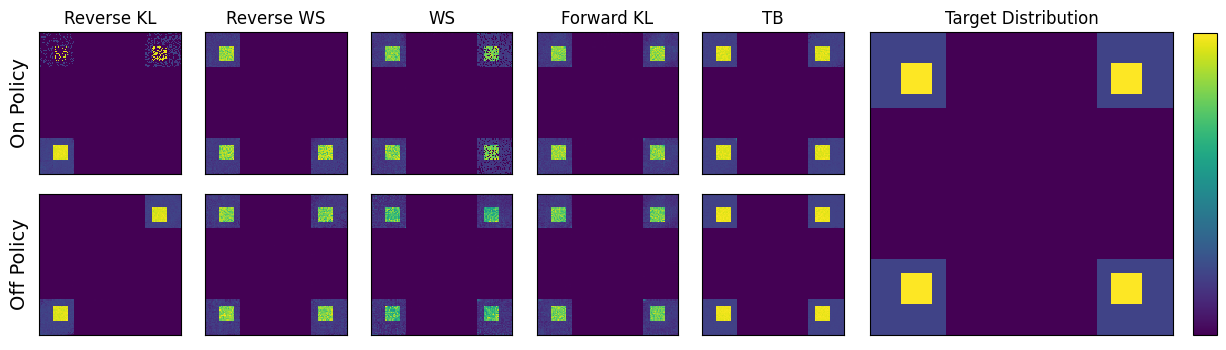

In [21]:
better_mode_names = {'Trajectory Balance': 'TB', 'Reverse KL': 'Reverse KL', 'RWS': 'WS', 'Forward KL': 'Forward KL', 'Reverse RWS': 'Reverse WS'}
fig = plt.figure(figsize=(12, 3.6))
fig.set_tight_layout(True)
for i, sampling_mode in enumerate(['On-Policy', 'Off-Policy']):
    for j, mode in enumerate(['Reverse KL', 'Reverse RWS', 'RWS', 'Forward KL', 'Trajectory Balance']):
        key = f"{mode}_{sampling_mode}"
        ax = plt.subplot2grid((2, 7), (i, j), colspan=1, rowspan=1)
        # ax.imshow(average_images[key], cmap='viridis', interpolation='none', vmin=0, vmax=1)
        ax.imshow(random_images[key], cmap='viridis', interpolation='none', vmin=0, vmax=1)

        ax.set_xticks([])
        ax.set_yticks([])
        if sampling_mode == 'On-Policy':
            ax.set_title(better_mode_names[mode])
        if j == 0:
            ax.set_ylabel(sampling_mode.replace('-', ' '), fontsize=14)
ax = plt.subplot2grid((2, 7), (0, 5), colspan=2, rowspan=2)
ax.imshow(truev, cmap='viridis', interpolation='none')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Target Distribution')
# add colorbar to the right of the subplot2grid
cax = fig.add_axes([1, 0.055, 0.02, 0.84])
cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=0, vmax=1), cmap='viridis'), cax=cax, ticks=[])
plt.savefig('final_distributions_2rows.pdf', bbox_inches='tight')
plt.show()



### Now do the same for the smaller environments

In [191]:
runs = api.runs("user_nameame/project_name")
small_runs_medium = []
small_runs_easy = []
for run in runs:
    if 'best_baseline' in run.tags:
        if run.config['env'] == 'easy':
            small_runs_easy.append(run)
        elif run.config['env'] == 'medium2':
            small_runs_medium.append(run)


In [192]:
sampling_mode = 'on_policy'
def get_groups_and_configs(runs):
    groups = {}
    configs = {}
    for mode in ['tb', 'reverse_kl', 'rws', 'forward_kl', 'reverse_rws']:
        name = mode
        groups[name] = []
        configs[name] = []
        for run in runs:
            if run.config['mode'] == mode and run.config['sampling_mode'] == sampling_mode:
                groups[name].append(run.history())
                configs[name].append(run.config)
    return groups, configs

excluded_keys = ['seed', 'wandb', 'offset', 'no_cuda', 'task_id', 'config_id', 'gradient_estimation_interval', 'validation_interval', 'total']

def complete_array(array, length):
    "takes an array and a desired length. If the array is shorter than the desired length, it is padded with the last value of the array"
    if len(array) < length:
        return np.concatenate((array, np.ones(length - len(array)) * array[-1]))
    return array

def get_group_average(group, column_name):
    "takes a list of dataframes as input and returns a numpy array of the average of the column across the dataframes, and same for std"
    matrix = [np.array(df[column_name].astype(float)) for df in group]
    max_length = max([len(m) for m in matrix])
    matrix = [complete_array(m, max_length) for m in matrix]
    return (np.mean(np.array(matrix), axis=0), np.std(np.array(matrix), axis=0))


In [193]:
groups_medium, configs_medium = get_groups_and_configs(small_runs_medium)
groups_easy, configs_easy = get_groups_and_configs(small_runs_easy)

/var/folders/48/q7zy1z255gbbzwwgxlsz6s980000gn/T/ipykernel_90872/2949045611.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels([f"{int(x/1000)}k" for x in axes[i].get_xticks()])


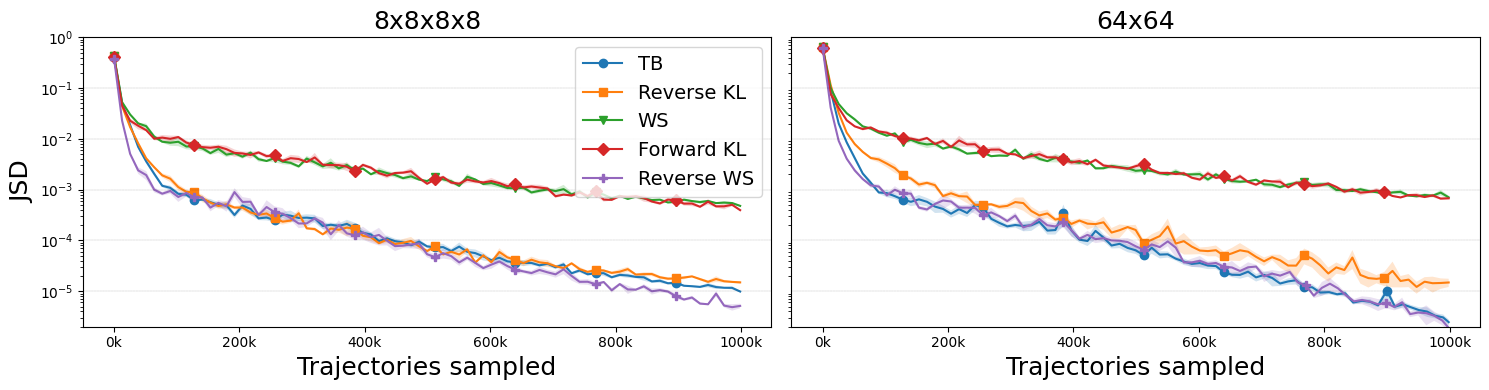

In [195]:

fig, axes = plt.subplots(1, 2, figsize=(15, 4))
fig.set_tight_layout(True)
markers = ['o', 's', 'v', 'D', 'P', 'H', 'X']
pretty_names = {'tb': 'TB', 'reverse_kl': 'Reverse KL', 'rws': 'WS', 'forward_kl': 'Forward KL', 'reverse_rws': 'Reverse WS'}
envs = ['8x8x8x8', '64x64']
envs_to_groups_and_configs = {'64x64': (groups_medium, configs_medium), '8x8x8x8': (groups_easy, configs_easy)}

for i, env in enumerate(envs):
    groups, configs = envs_to_groups_and_configs[env]
    for j, mode in enumerate(['tb', 'reverse_kl', 'rws', 'forward_kl', 'reverse_rws']):
        mean, std = get_group_average(groups[mode], 'jsd')
        states_visited, _ = get_group_average(groups[mode], 'states_visited')
        standard_error = std / np.sqrt(len(groups[mode]))
        axes[i].plot(states_visited, mean, label=pretty_names[mode], marker=markers[j], markevery=10)
        axes[i].fill_between(states_visited, mean - standard_error, mean + standard_error, alpha=0.2)
    # make the y axis log scale
    axes[i].set_yscale('log')
    axes[i].set_title(env, fontsize=18)

    axes[i].set_ylim(2e-6, 1)
    if i == 0:
        axes[i].legend(prop={'size': 14})
        axes[i].set_ylabel('JSD', fontsize=18)
    if i != 0:
        axes[i].set_yticks([])
    axes[i].set_xlabel('Trajectories sampled', fontsize=18)
    axes[i].set_xticklabels([f"{int(x/1000)}k" for x in axes[i].get_xticks()])
    # add thin horizontal lines
    for y in [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]:
        axes[i].axhline(y=y, color='k', linestyle='--', linewidth=0.1)

plt.savefig('comparing_all_modes_on_off_policy_small.pdf', bbox_inches='tight')
plt.show()



In [196]:
# download images of 2d distributions

import os
for run in small_runs_medium:
    mode = run.config['mode']
    name = f"{mode}"
    print(f"Processing {run.name}")
    iteration = max([int(x['path'].split('P_T_')[1].split('_')[0]) for x in run.history()['P_T'].values])
    name = f"{run.config['mode']}_best_{run.config['seed']}"
    for file in run.files():
        if 'P_T' in file.name and str(iteration) in file.name:
            file.download(replace=True)
            file_directory = os.path.join(os.getcwd(), 'media', 'images')
            os.rename(file.name, os.path.join(file_directory, f"{name}.png"))

Processing hvi_paper_smallenvs_109
Processing hvi_paper_smallenvs_110
Processing hvi_paper_smallenvs_91
Processing hvi_paper_smallenvs_89
Processing hvi_paper_smallenvs_93
Processing hvi_paper_smallenvs_95
Processing hvi_paper_smallenvs_85
Processing hvi_paper_smallenvs_86
Processing hvi_paper_smallenvs_69
Processing hvi_paper_smallenvs_71
Processing hvi_paper_smallenvs_65
Processing hvi_paper_smallenvs_61
Processing hvi_paper_smallenvs_62
Processing hvi_paper_smallenvs_67
Processing hvi_paper_smallenvs_47
Processing hvi_paper_smallenvs_45
Processing hvi_paper_smallenvs_43
Processing hvi_paper_smallenvs_41
Processing hvi_paper_smallenvs_38
Processing hvi_paper_smallenvs_37
Processing hvi_paper_smallenvs_113
Processing hvi_paper_smallenvs_14
Processing hvi_paper_smallenvs_17
Processing hvi_paper_smallenvs_19
Processing hvi_paper_smallenvs_13
Processing hvi_paper_smallenvs_21
Processing hvi_paper_smallenvs_23
Processing hvi_paper_smallenvs_115
Processing hvi_paper_smallenvs_117
Processin

In [197]:

from PIL import Image
import os
import matplotlib

def filename_to_mode(filename):
    if 'forward_kl' in filename:
        return 'Forward KL'
    elif 'reverse_kl' in filename:
        return 'Reverse KL'
    elif 'reverse_rws' in filename:
        return 'Reverse RWS'
    elif 'modified_db' in filename:
        return 'Modified DB'
    elif 'tb' in filename:
        return 'Trajectory Balance'
    elif 'rws' in filename:
        return 'RWS'
    else:
        return 'Unknown'


files = os.listdir('media/images')
algs = [ f[:-4] for f in files ]
algos = {}
for image in files:
    if 'best' not in image or 'policy' in image:
        continue
    key = filename_to_mode(image)
    if key not in algos.keys():
        algos[key] = []
    image = np.array(Image.open(os.path.join('media/images', image))) / 255. 
    g = image[62:445:3,66:449:3]
    c = np.array(matplotlib.cm.viridis.colors)
    v = ((g[...,:3,None]-c.T)**2).sum(-2).argmin(-1) / 255.
    algos[key].append(v[::-1])





In [198]:
average_images = {key: np.array(val).mean(0) for key, val in algos.items()}

# target distribution
truev = np.copy(algos['Trajectory Balance'][1])
truev[(truev>0)*(truev<100/255.)] = 51/255.
truev[truev>51/255.]=1

average_images = average_images.copy()
random_images = {}
for key, val in average_images.items():
    average_images[key] = average_images[key] + np.array(algos[key]).std(0) * np.random.randn(*np.array(algos[key]).std(0).shape) * .5
    random_images[key] = np.zeros(algos[key][0].shape)
    for i in range(random_images[key].shape[0]):
        for j in range(random_images[key].shape[1]):
            random_images[key][i, j] = algos[key][np.random.randint(len(algos[key]))][i, j]


/var/folders/48/q7zy1z255gbbzwwgxlsz6s980000gn/T/ipykernel_90872/568429960.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('final_distributions_small.pdf', bbox_inches='tight')
/var/folders/48/q7zy1z255gbbzwwgxlsz6s980000gn/T/ipykernel_90872/568429960.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('final_distributions_small.pdf', bbox_inches='tight')
/Users/user_name/opt/miniconda3/envs/gfn/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


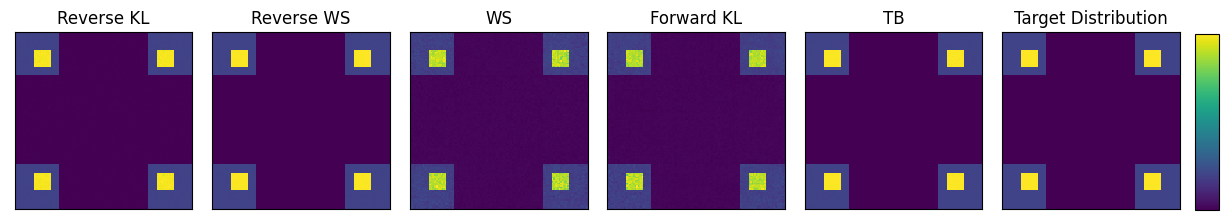

In [199]:
better_mode_names = {'Trajectory Balance': 'TB', 'Reverse KL': 'Reverse KL', 'RWS': 'WS', 'Forward KL': 'Forward KL', 'Reverse RWS': 'Reverse WS'}
fig = plt.figure(figsize=(12, 3.6))
fig.set_tight_layout(True)
for j, mode in enumerate(['Reverse KL', 'Reverse RWS', 'RWS', 'Forward KL', 'Trajectory Balance']):
    key = f"{mode}"
    ax = plt.subplot2grid((1, 6), (0, j), colspan=1, rowspan=1)
    # ax.imshow(average_images[key], cmap='viridis', interpolation='none', vmin=0, vmax=1)
    ax.imshow(random_images[key], cmap='viridis', interpolation='none', vmin=0, vmax=1)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(better_mode_names[mode])

ax = plt.subplot2grid((1, 6), (0, 5), colspan=1, rowspan=1)
ax.imshow(truev, cmap='viridis', interpolation='none')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Target Distribution')
# add colorbar to the right of the subplot2grid
cax = fig.add_axes([1, 0.25, 0.02, 0.49])
cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=0, vmax=1), cmap='viridis'), cax=cax, ticks=[])
plt.savefig('final_distributions_small.pdf', bbox_inches='tight')
plt.show()

